In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from dataloader.depthloader import load_calib_cam_to_cam, disparity_loader
from utils.flowlib import read_flow, flow_to_image

In [2]:
## to be modified
data_path = '/media/denis/SSD_A/kitti/data_scene_flow' # point to your KITTI data
pose_path = "/home/denis/open_source/expansion/precomputed/precomputed-kitti-v3/precomputed/pose"
monodepth_path = "/home/denis/open_source/expansion/precomputed/precomputed-kitti-v3/precomputed/monodepth2"
pred_path = '/home/denis/open_source/expansion/precomputed/precomputed-kitti-v3/precomputed/exp-kitti-train' # point to the predictions

In [5]:
# Sec 1. Scene flow results on KITTI validation set (Tab.1 in the paper)
d1_errs = [] # D1-err
d2_errs = [] # D2-err
fl_errs = [] # Fl-err
sf_err = [] # SF-err
for idnum in range(0,200,5):
    print('id: %d'%idnum)
    impath = '%s/training/image_2/%06d_10.png'%(data_path,idnum)
    framename = int(impath.split('/')[-1].split('_')[-2])

    # load ground-truth and masks for valid pixels
    flow_gt = read_flow('%s/training/flow_occ/%06d_10.png'%(data_path,framename)).astype(np.float32)
    disp0_gt = disparity_loader('%s/training/disp_occ_0/%06d_10.png'%(data_path,idnum))
    d1mask_gt = disp0_gt>0
    disp1_gt = disparity_loader('%s/training/disp_occ_1/%06d_10.png'%(data_path,idnum))
    d2mask_gt = disp1_gt>0
    shape = flow_gt.shape[:2]

    # load images and intrinsics
    im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
    im_nf = cv2.imread('%s/training/image_2/%06d_11.png'%(data_path,framename))
    ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(data_path,framename))
    K0 = ints['K_cam2']
    bl = ints['b20']-ints['b30']
    K1 = K0.copy()

    # load pre-computed results; tau is the motion-in-depth, and disp0 represents the first-frame disparity (inverse depth)
    flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
    tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))
    
    disp0 = disparity_loader('%s/2015/%06d_10_disp.pfm'%(monodepth_path, framename))
    # For lidar scene flowl, replace disp0 with sparse idar depth projection (inversed)
    # For stereo scene flow, replace disp0 with stereo disaprity
    
    # compute 2nd frame disp
    disp1 = disp0/tau
   
    # compute errors
    d1err = np.abs(disp0-disp0_gt)
    d1err = np.logical_and(d1err>=3, d1err/disp0_gt>=0.05)
    d1err[~d1mask_gt]=0
    d1_errs.append(d1err[d1mask_gt])
      
    d2err = np.abs(disp1-disp1_gt)
    d2err = np.logical_and(d2err>=3, d2err/disp1_gt>=0.05)
    d2err[~d2mask_gt]=0
    d2_errs.append(d2err[d2mask_gt])
    
    epe_map = np.sqrt(np.power(flow_gt[:,:,:2] - flow[:,:,:2],2).sum(-1))
    gt_mag_map = np.sqrt(np.power(flow_gt[:,:,:2],2).sum(-1))
    flerr = np.logical_and(epe_map > 3, epe_map/gt_mag_map > 0.05)
    fl_errs.append( flerr[flow_gt[:,:,-1].astype(bool)]  )
    
    
    sf_err += list(np.logical_or(np.logical_or(flerr[flow_gt[:,:,-1].astype(bool)],d2err[flow_gt[:,:,-1].astype(bool)]),d1err[flow_gt[:,:,-1].astype(bool)]))

id: 0
id: 5


/home/denis/pt_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/denis/pt_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/home/denis/pt_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


id: 10
id: 15
id: 20
id: 25
id: 30
id: 35
id: 40
id: 45
id: 50
id: 55
id: 60
id: 65
id: 70
id: 75
id: 80
id: 85
id: 90
id: 95
id: 100
id: 105
id: 110
id: 115
id: 120
id: 125
id: 130
id: 135
id: 140
id: 145
id: 150
id: 155
id: 160
id: 165
id: 170
id: 175
id: 180
id: 185
id: 190
id: 195


In [6]:
print('d1-err:%.2f'%(np.mean(np.concatenate(d1_errs))*100))
print('d2-err:%.2f'%(np.mean(np.concatenate(d2_errs))*100))
print('fl-err:%.2f'%(np.mean(np.concatenate(fl_errs))*100))
print('sf-err:%.2f'%(np.mean(sf_err)*100))

d1-err:14.65
d2-err:16.82
fl-err:6.00
sf-err:19.74


(-0.5, 1240.5, 375.5, -0.5)

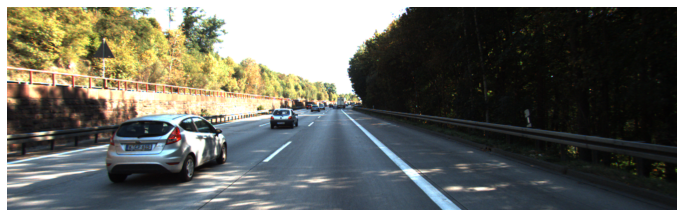

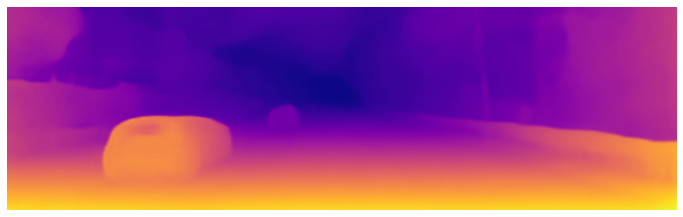

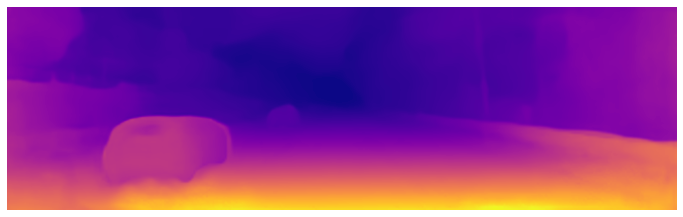

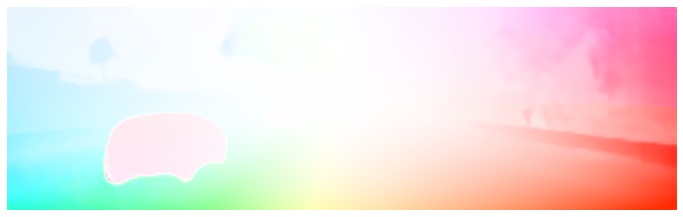

In [7]:
plt.figure(figsize=(12,4)); plt.imshow(im[:,:,::-1]); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp0,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(disp1,cmap='plasma'); plt.axis('off')
plt.figure(figsize=(12,4)); plt.imshow(flow_to_image(flow),cmap='plasma'); plt.axis('off')

In [8]:
def min_max_compute(data):
    min_d = np.min(data)
    max_d = np.max(data)
    print(f"min_d {min_d}, max_d {max_d}")
    return (data- min_d)/ (max_d -min_d)

In [9]:
def sampson_error_f(F, pts1, pts2):
    
    """
    F = 3x3
    pts1 = 3 x n
    pts2 = 3x n
    
    """
    
    Fp1 = np.matmul(F, pts1)
    Fp2 = np.matmul(F.T, pts2)
    p2Fp1 = np.einsum("ji, ji->i", pts2, Fp1)
    
    error = (p2Fp1**2) / (Fp1[0]**2 + Fp2[0]**2 + Fp1[1]**2 + Fp2[1]**2)
    return error

In [43]:
# Sec 2. Two-frame depth estimation  (Sec.4.5 in the paper)
# using frame 000195 as an example
# camera poses are computed by fitting essential matrix with RANSAC
framename=100


RT = np.loadtxt('%s/%06d_10.txt'%(pose_path, framename))
R = RT[:3,:3]
T = RT[:3,-1]

S = np.asarray( [ [0.0, -T[2], T[1] ], [T[2], 0.0, -T[0]], [-T[1], T[0], 0.0]])

flow = read_flow('%s/2015/flo-%06d_10.pfm'%(pred_path,framename)).astype(np.float32)
#tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))
tau = np.exp(disparity_loader('%s/2015/mid-%06d_10.pfm'%(pred_path,framename)))

im = cv2.imread('%s/training/image_2/%06d_10.png'%(data_path,framename))
shape = tau.shape
ints = load_calib_cam_to_cam('%s/training/calib_cam_to_cam/%06d.txt'%(data_path,framename))
K0 = ints['K_cam2']
bl = ints['b20']-ints['b30']
K1 = K0.copy()

# depth from flow-triangulation
x0,y0=np.meshgrid(range(shape[1]),range(shape[0]))
x0=x0.astype(np.float32)
y0=y0.astype(np.float32)
x1=x0+flow[:,:,0]
y1=y0+flow[:,:,1]
hp0 = np.concatenate((x0[np.newaxis],y0[np.newaxis],np.ones(x1.shape)[np.newaxis]),0).reshape((3,-1))
hp1 = np.concatenate((x1[np.newaxis],y1[np.newaxis],np.ones(x1.shape)[np.newaxis]),0).reshape((3,-1))

x1_dash = np.matmul(np.eye(3), np.matmul(np.linalg.inv(K0), hp0))
x2_dash = np.matmul( R , np.matmul(np.linalg.inv(K1), hp1))


samson_error = sampson_error_f(S,x2_dash, x1_dash,   ).reshape(shape)
                    


P_pred = cv2.triangulatePoints(K0.dot(np.concatenate( (np.eye(3),np.zeros((3,1))), -1)), 
                         K1.dot(np.concatenate( (R.T,-R.T.dot(T[:,np.newaxis])), -1)), 
                         hp0[:2],hp1[:2])
P_pred = P_pred[:3]/P_pred[-1:]  
disp_flow = 1./P_pred[-1].reshape(shape)
print(f"disp_flow {np.min(disp_flow)}, max {np.max(disp_flow)}")


disp_flow -0.4709034669287929, max 1.3386565702209792


In [44]:
# depth from up-to-scale flow
H01 = K0.dot(R).dot(np.linalg.inv(K1)) # remove the effect of camera rotation
hp1 = H01.dot(hp1)
# it can be proved that up to scale 3D flow = (ux, uy, uz)/d0(x,y) = K^{-1}(tau*p1-p0), tau = d1/d0
p3d = np.transpose(np.linalg.inv(K0).dot(tau.flatten()[np.newaxis]*hp1-hp0),[1,0])
disp_p3d = np.linalg.norm(p3d,2,1).reshape(shape) # forcing unit norm yields the disparity of the rigid pixels
print(f"disp_p3d {np.min(disp_p3d)}, max {np.max(disp_p3d)}")


disp_p3d 0.00048566193734108954, max 0.47474855931857135


In [41]:

def normalize_angle(angle):
    """
    The function normalizes angle between
    -pi to pi values
    Arguments:
    angle: in radians
    Returns:
    angle: between -pi/2 to pi/2 in radians
    """
    while (angle > np.pi/2.0).any():
        mask = angle > np.pi/2.0
        angle[mask] -= 2 * np.pi
    while (angle < -np.pi/2.0).any():
        mask =  angle < -np.pi/2.0
        angle[mask] += 2 * np.pi
    return angle
def compute_sin(scene_flow, T):
    
    v1 = scene_flow / np.linalg.norm(scene_flow, axis=1)[..., None]
    v2 = -T / np.linalg.norm(T)
    dot_product = np.dot(v1, v2)
    angle = normalize_angle(np.arccos(dot_product))
    print(angle)
    return np.sin(angle)

depth_contrast  min 9.029109183156307e-07 max 1.0
[0.55749533 0.54894131 0.34053394 ... 1.2724074  1.2792727  1.27946302]
min_d 6.484166084233824e-07, max_d 0.46900789568836204
min_d 1.0243276583513289e-18, max_d 0.001206586762986054


/home/denis/pt_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/home/denis/pt_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log


(-0.5, 1241.5, 374.5, -0.5)

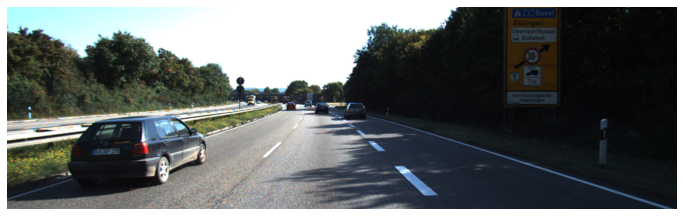

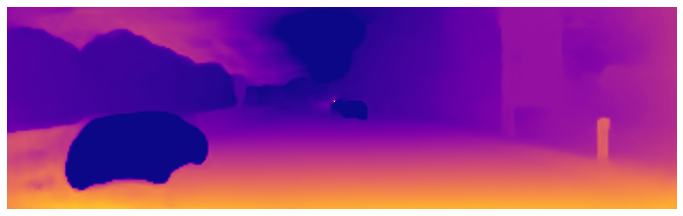

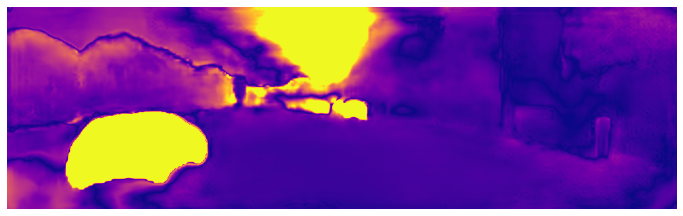

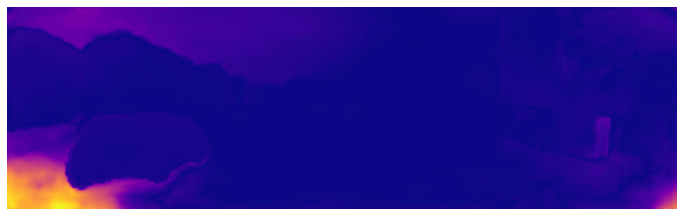

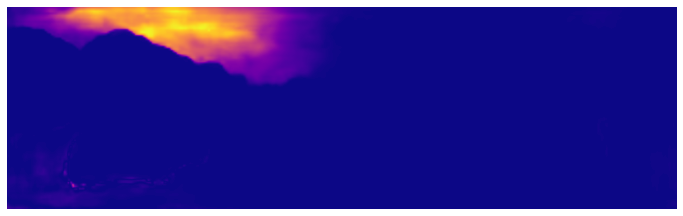

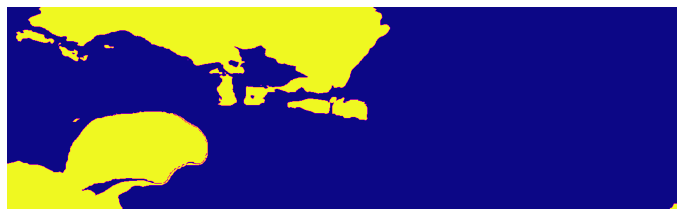

In [42]:
plt.figure(figsize=(12,4)); plt.imshow(im[:,:,::-1]); plt.axis('off')
# depth monodepth2
disp0 = disparity_loader('%s/2015/%06d_10_disp.pfm'%(monodepth_path, framename))
#plt.figure(figsize=(12,4)); plt.imshow(disp0,cmap='plasma'); plt.axis('off')
# flow-triangulated depth
plt.figure(figsize=(12,4)); plt.imshow(disp_flow,vmax=0.4,vmin=0,cmap='plasma'); plt.axis('off')
# depth from up-to-scale flow
#plt.figure(figsize=(12,4)); plt.imshow(disp_p3d,vmax=0.4,vmin=0,cmap='plasma'); plt.axis('off')
# diff 
disp_median = np.median(disp0)
flow_median = np.median(disp_flow)
expansion_median = np.median(disp_p3d)

scale_flow_disp = disp_median / flow_median

depth_contrast = np.abs(np.log(scale_flow_disp * disp_flow /disp0))
depth_contrast = np.clip(depth_contrast, 0.0, 1.0)
depth_contrast[np.isnan(depth_contrast)] = 1.0

#plt.figure(figsize=(12,4)); plt.imshow(depth_contrast,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')
scale_flow_expansion = expansion_median / flow_median
print(f"depth_contrast  min {np.min(depth_contrast)} max {np.max(depth_contrast)}")

depth_contrast2 = np.abs(np.log(scale_flow_expansion * disp_flow /disp_p3d))
depth_contrast2 = np.clip(depth_contrast2, 0.0, 1.0)
depth_contrast2[np.isnan(depth_contrast2)] = 1.0
#print(f"depth_contrast2  min {np.min(depth_contrast2)} max {np.max(depth_contrast2)}")
plt.figure(figsize=(12,4)); plt.imshow(depth_contrast2,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')

#diff = np.abs( disp_flow  - disp_p3d)

#plt.figure(figsize=(12,4)); plt.imshow(diff,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')

# Compute angle
sin_b = compute_sin(p3d, T).reshape(shape)

error = np.linalg.norm(p3d, axis=1).reshape(shape) * np.abs(sin_b)
norm_error = min_max_compute(error)
plt.figure(figsize=(12,4)); plt.imshow(norm_error,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')

norm_samson = min_max_compute(samson_error)
plt.figure(figsize=(12,4)); plt.imshow(norm_samson,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')
total_mask = (norm_samson + norm_error + depth_contrast2) / 3.0

plt.figure(figsize=(12,4)); plt.imshow(total_mask>0.2,vmax=1.0,vmin=0,cmap='plasma'); plt.axis('off')

